# Relation Extraction from Tables

This notebook demonstrates the full extraction and learning process for _relations_ in tables with a data set of transistor spec sheets, extracting (temperature label, min storage temperature) pairs. (Eventually, this tutorial will be updated to extract (part number, min storage temperature) pairs.

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extraction

Use this option if you would like to unpickle a previously parsed corpus, (i.e., the corpus from the Entity Extraction notebook).

In [2]:
load_pickle = True
corpus_loaded = False

if load_pickle:
    try:
        import cPickle
        with open("data/hardware/hardware_corpus.pkl","r") as pkl:
            %time corpus = cPickle.load(pkl)
        corpus_loaded = True
        print "Corpus has been loaded."
    except:
        print "Corpus could not be loaded."
        print "Corpus will be parsed instead..."
if not corpus_loaded:
    from snorkel.parser import CorpusParser
    from snorkel.parser import HTMLParser
    from snorkel.parser import TableParser

    html_parser = HTMLParser(path='data/hardware/hardware_html/')
    table_parser = TableParser()

    cp = CorpusParser(html_parser, table_parser, max_docs=15)
    %time corpus = cp.parse_corpus(name='Hardware Corpus')
    print "Corpus has been parsed."

CPU times: user 17.1 s, sys: 980 ms, total: 18.1 s
Wall time: 18.5 s
Corpus has been loaded.


We now create two EntityExtractor objects, one for each component in the relation.

In [3]:
from snorkel.candidates import TableNgrams, EntityExtractor, RelationExtractor
from snorkel.matchers import RegexMatchEach, DictionaryMatch, RangeMatcher
from load_dictionaries import load_hardware_dictionary

# Select a CandidateSpace
table_ngrams = TableNgrams(n_max=3)

# Entity Extractor 1: Part numbers
parts = load_hardware_dictionary()
print "Loaded %s part numbers." % len(parts)

# NOTE: this will not catch items in ranges (e.g., BC546-BC548) or lists (e.g., BC546/547/548)
part_matcher = DictionaryMatch(d=parts, longest_match_only=False)
part_extractor = EntityExtractor(table_ngrams, part_matcher)

# Entity Extractor 2: Temperatures (min storage temperature)
# temp_matcher = RangeMatcher(low=140,high=160)
temp_matcher = RegexMatchEach(rgx=r'1[3-7][05]', attrib='words')
temp_extractor = EntityExtractor(table_ngrams, temp_matcher)

# Relation Extractor:
relation_extractor = RelationExtractor(part_extractor, temp_extractor)

Loaded 179 part numbers.


In [4]:
# %time candidates = temp_extractor.extract(corpus.get_tables(), name='all')
%time candidates = relation_extractor.extract(corpus.get_tables(), name='all')

for cand in candidates[:10]: 
    print cand
print "%s candidates extracted" % len(candidates)

CPU times: user 1min 8s, sys: 2.08 s, total: 1min 10s
Wall time: 1min 11s
NgramPair(BC546, 150, Table=5)
NgramPair(BC546, 150, Table=5)
NgramPair(BC546, 150, Table=5)
NgramPair(BC547, 150, Table=5)
NgramPair(BC547, 150, Table=5)
NgramPair(BC547, 150, Table=5)
NgramPair(BC548, 150, Table=5)
NgramPair(BC548, 150, Table=5)
NgramPair(BC548, 150, Table=5)
NgramPair(BC546, 150, Table=5)
741 candidates extracted


In [5]:
from utils import collect_hardware_relation_gold
filename = 'data/hardware/gold_all.csv'
gt_dict = collect_hardware_relation_gold(filename, 'stg_temp_max', candidates)
print "%s out of %s candidates have gold labels" % (len(gt_dict),len(candidates))
print "%s out of %s labeled candidates have positive label" \
        % (gt_dict.values().count(1), len(gt_dict))

179 gold annotations available
741 out of 741 candidates have gold labels
573 out of 741 labeled candidates have positive label


In [6]:
from snorkel.features import TableNgramPairFeaturizer
featurizer = TableNgramPairFeaturizer()
featurizer.fit_transform(candidates)
for f in featurizer.get_features_by_candidate(candidates[0])[:10]: print f

e0_DDLIB_WORD_SEQ_[BC546]
e0_DDLIB_LEMMA_SEQ_[bc546]
e0_DDLIB_POS_SEQ_[NN]
e0_DDLIB_DEP_SEQ_[appos]
e0_DDLIB_W_LEFT_1_[-rrb-]
e0_DDLIB_W_LEFT_POS_1_[-RRB-]
e0_DDLIB_W_LEFT_2_[mhz -rrb-]
e0_DDLIB_W_LEFT_POS_2_[NN -RRB-]
e0_DDLIB_W_LEFT_3_[_NUMBER mhz -rrb-]
e0_DDLIB_W_LEFT_POS_3_[CD NN -RRB-]


In [7]:
from snorkel.snorkel import DDLiteModel
DDL = DDLiteModel(candidates, featurizer.fit_transform(candidates), gt_dict)

DDL.set_holdout(idxs=range(int(len(gt_dict)*.5)), validation_frac=0.5)
print "%s training data" % len(DDL.gt.get_labeled_ground_truth('training')[0])
print "%s test data" % len(DDL.gt.get_labeled_ground_truth('test')[0])
print "%s validation data" % len(DDL.gt.get_labeled_ground_truth('validation')[0])

371 training data
185 test data
185 validation data


In [8]:
# Part number LFs
# TODO

# Temperature LFs
def LF_to_range(m):
    return 1 if 'to' in m.ngram1.pre_window('words') else 0
def LF_tilde_range(m):
    return 1 if '~' in m.ngram1.pre_window('words') else 0
def LF_storage(m):
    return 1 if 'storage' in m.ngram1.aligned_ngrams('words') else -1
def LF_tstg(m):
    return 1 if 'tstg' in m.ngram1.aligned_ngrams('words') else -1
def LF_tj(m):
    return 1 if 'tj' in m.ngram1.aligned_ngrams('words') else -1
def LF_temperature(m):
    return 1 if 'temperature' in m.ngram1.aligned_ngrams('words') else -1
def LF_celsius(m):
    return 1 if 'c' in m.ngram1.aligned_ngrams('words') else 0
def LF_max(m):
    return 1 if 'max' in m.ngram1.aligned_ngrams('lemmas') else 0
def LF_min(m):
    return 1 if 'min' in m.ngram1.aligned_ngrams('lemmas') else 0

# Combined LFs
def LF_same_row(m):
    return 1 if m.ngram0.context.row_num == m.ngram1.context.row_num else 0
def LF_same_col(m):
    return 1 if m.ngram0.context.col_num == m.ngram1.context.col_num else 0

# NOTE: don't forget to add LF name to LFs below

In [9]:
LFs = [LF_to_range, LF_tilde_range, LF_storage, LF_tstg, LF_tj, LF_temperature, 
       LF_max, LF_min, LF_same_row, LF_same_col]
DDL.apply_lfs(LFs, clear=True)

In [10]:
print DDL.lf_names
DDL.print_lf_stats()

['LF_to_range', 'LF_tilde_range', 'LF_storage', 'LF_tstg', 'LF_tj', 'LF_temperature', 'LF_max', 'LF_min', 'LF_same_row', 'LF_same_col']
LF stats on training set
Coverage:	100.000%
Overlap:	100.000%
Conflict:	50.404%


In [11]:
DDL.lowest_coverage_lfs(n=10)

Labeling function,Candidate coverage
LF_to_range,0.00%
LF_same_col,1.62%
LF_storage,100.00%
LF_tj,100.00%
LF_temperature,100.00%
LF_tstg,100.00%
LF_min,21.02%
LF_tilde_range,3.23%
LF_max,4.04%
LF_same_row,6.74%


Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.449139
	Learning epoch = 250	Gradient mag. = 0.458563
Final gradient magnitude for rate=0.01, mu=1e-07: 0.488
Running in False mode...
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.125450
	Learning epoch = 250	Gradient mag. = 0.131457
	Learning epoch = 500	Gradient mag. = 0.130871
	Learning epoch = 750	Gradient mag. = 0.130293
	Learning epoch = 1000	Gradient mag. = 0.129723
	Learning epoch = 1250	Gradient mag. = 0.129161
	Learning epoch = 1500	Gradient mag. = 0.128607
	Learning epoch = 1750	Gradient mag. = 0.128062
	Learning epoch = 2000	Gradient mag. = 0.127523
	Learning epoch = 2250	Gradient mag. = 0.126993
	Learning epoch = 2500	Gradient mag. = 0.126470
	Learning epoch = 2750	Gradient mag. = 0.125954
Final gradient magnitude for rate=0.01, mu=1e-09: 0.125
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.125450
	Learning epoch = 250	Gradient mag. = 0

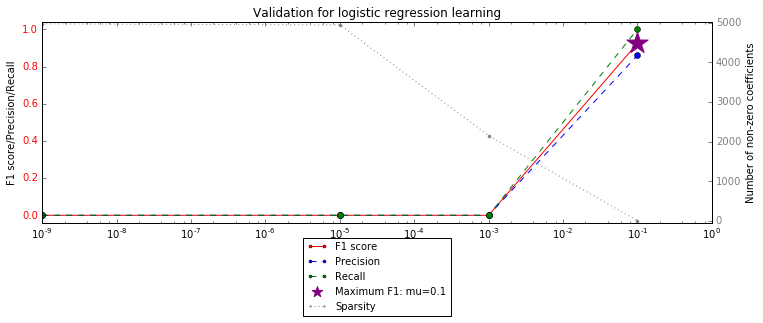

CPU times: user 16.2 s, sys: 242 ms, total: 16.4 s
Wall time: 9.53 s


<snorkel.snorkel.ModelLog instance at 0x112c6a758>

In [12]:
import matplotlib
import numpy as np
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)